In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [47]:
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes, ExcitationPreserving, TwoLocal, EfficientSU2
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import scipy.sparse.linalg

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import os
import json
import math

In [3]:
h_b_AHO = 0.5*(p*p) + 0.5*(m*q+g*q**3)**2
h_f_AHO = -0.5*(m+3*g*q*q)#[bdag,b]

cutoff=16

ham=Hamiltonian(h_b_AHO,h_f_AHO,{m:1, g:1}, cutoff, standard_encode)


In [4]:
hamOP = pauli_string_to_op(ham.pauliStrings)
nq=math.floor(math.log2(ham.hamMatrix.shape[0]))
if not math.log2(ham.hamMatrix.shape[0]).is_integer():
    nq+=1

In [5]:
estimator = Estimator()
sampler=Sampler()
fidelity=ComputeUncompute(sampler)

ansatz = RealAmplitudes(nq, entanglement='linear', reps=2)

In [6]:
k=3
betas=[1,1,1]

counts=[]
values=[]
steps=[]

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [7]:
print("------ cutoff = {} ------".format(cutoff))
#CLASSICAL COMPUTATION OF GROUND STATE ENERGY
ens=scipy.sparse.linalg.eigs(getMatrix(ham.pauliStrings),k=7,sigma=0.0)[0]
print("Lowest 7 energies = {}".format(ens))
print("Min energy = {:.4e}".format(np.array([x.real for x in ens]).min()))

------ cutoff = 16 ------
Lowest 7 energies = [1.83029849e-03+5.14299722e-20j 1.70732190e+00+1.07013837e-16j
 1.68720122e+00-9.10849355e-17j 4.37401524e+00+7.38579770e-16j
 4.41418952e+00+2.08686804e-14j 7.76596507e+00-3.75443088e-16j
 7.94769938e+00-7.30049517e-17j]
Min energy = 1.8303e-03


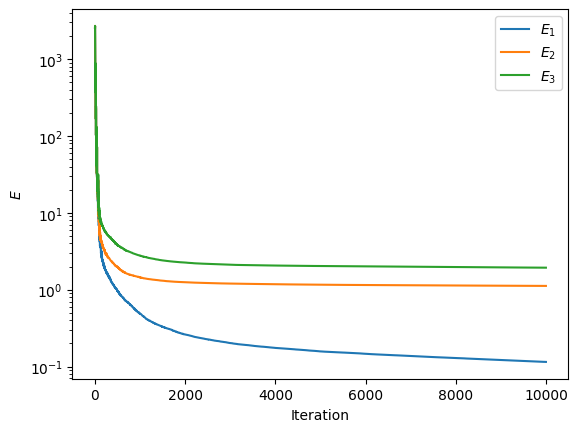

In [8]:
counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-4), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')

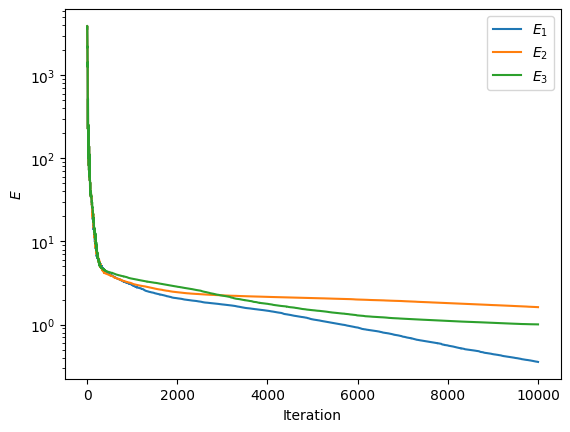

In [9]:
counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-8), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')

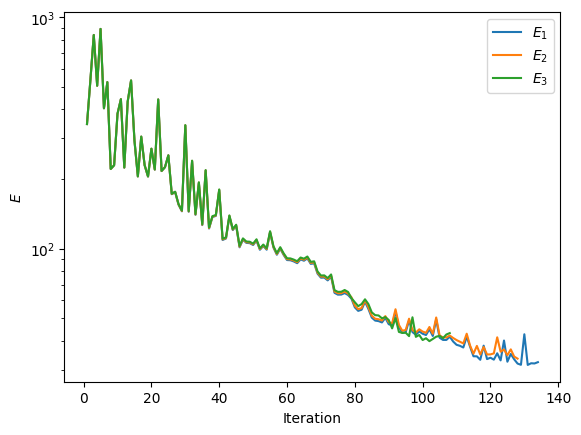

In [10]:
counts=[]
values=[]
steps=[]

vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=10000, tol=1e-1), k=k, betas=betas, callback=callback)
result=vqd.compute_eigenvalues(operator=hamOP)

counts=np.asarray(counts)
steps=np.asarray(steps)
values=np.asarray(values)
for i in range(1,k+1):
    _counts=counts[np.where(steps==i)]
    _values=values[np.where(steps==i)]
    plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
plt.xlabel(r'Iteration')
plt.ylabel(r'$E$')
plt.yscale('log')
plt.legend(loc='upper right')

## Trying different wavefuncs

In [40]:
estimator = Estimator()
sampler=Sampler()
fidelity=ComputeUncompute(sampler)


def run_for_ansatz(ansatz, maxiter=5000, tol=1e-4):
    k=3
    betas=[1,1,1]

    counts=[]
    values=[]
    steps=[]

    def callback(eval_count, params, value, meta, step):
        counts.append(eval_count)
        values.append(value)
        steps.append(step)

    vqd=VQD(estimator, fidelity, ansatz, optimizer=COBYLA(maxiter=maxiter, tol=tol), k=k, betas=betas, callback=callback)
    result=vqd.compute_eigenvalues(operator=hamOP)
    print(result.eigenvalues)
    counts=np.asarray(counts)
    steps=np.asarray(steps)
    values=np.asarray(values)
    
    for i in range(1,k+1):
        _counts=counts[np.where(steps==i)]
        _values=values[np.where(steps==i)]
        plt.plot(_counts,_values,label=r'$E_{{{}}}$'.format(i))
    plt.xlabel(r'Iteration')
    plt.ylabel(r'$E$')
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.title(r'{} ansatz, {} entanglement, {} reps'.format(ansatz.__class__.__name__,ansatz.entanglement, ansatz.reps))
    plt.show()

[0.01815771+0.j 1.02211443+0.j 2.06017682+0.j]


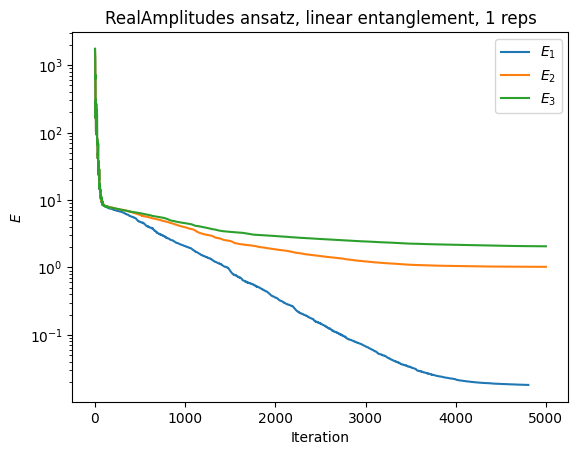

In [32]:
run_for_ansatz(RealAmplitudes(nq, entanglement='linear', reps=1))

[0.14879055+0.j 1.63856547+0.j 2.07124787+0.j]


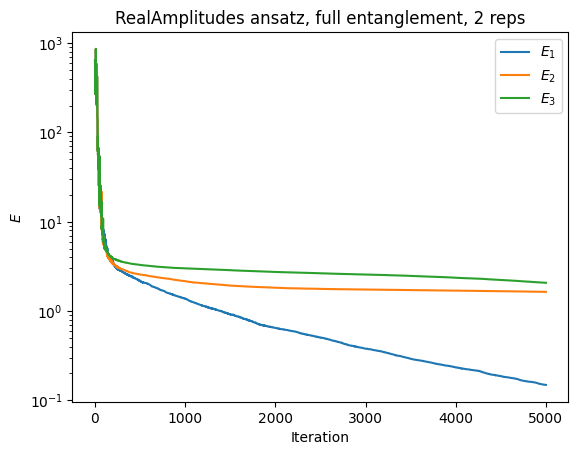

In [38]:
run_for_ansatz(RealAmplitudes(nq, entanglement='full', reps=2))

[0.08427152+0.j 1.75100034+0.j 1.70249676+0.j]


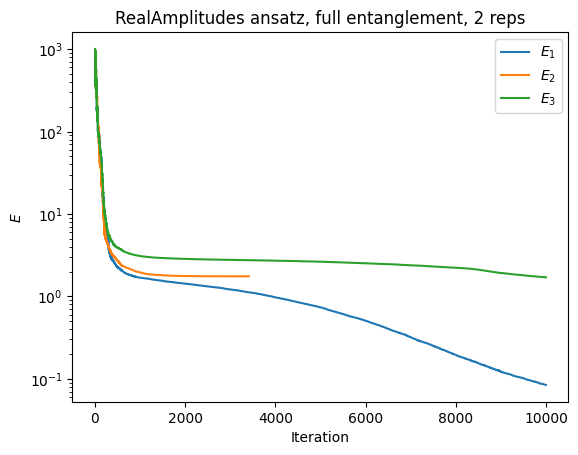

In [41]:
run_for_ansatz(RealAmplitudes(nq, entanglement='full', reps=2), maxiter=10000)

[0.69821953+0.j 1.41061281+0.j 4.75085798+0.j]


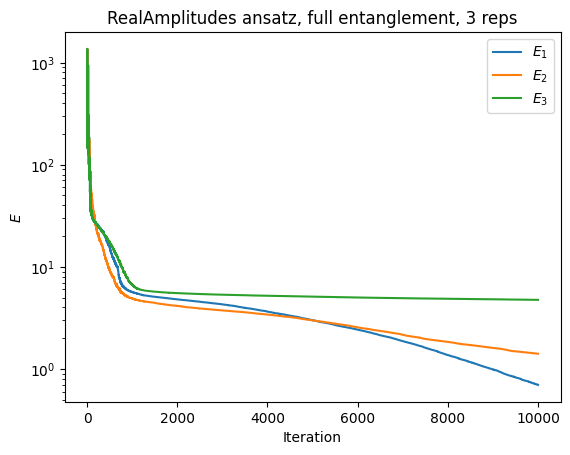

In [42]:
run_for_ansatz(RealAmplitudes(nq, entanglement='full', reps=3), maxiter=10000)

[3.4375+0.j 4.4375+0.j 5.4375+0.j]


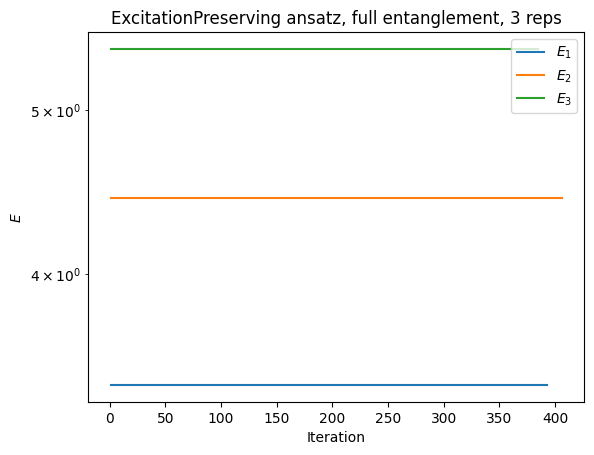

In [37]:
run_for_ansatz(ExcitationPreserving(nq, mode='iswap', entanglement='full', reps=3))

[0.86630284+0.j 2.03069194+0.j 0.89988119+0.j]


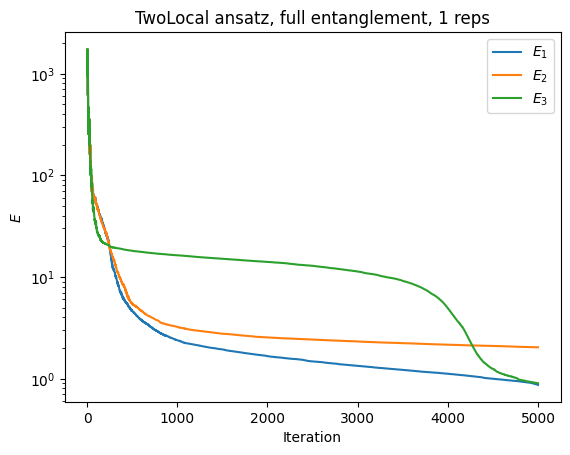

In [45]:
run_for_ansatz(TwoLocal(nq, rotation_blocks='ry', entanglement_blocks='cx', entanglement='full', reps=1),maxiter=5000)

[0.30884136+0.j 1.95125137+0.j 0.91391437+0.j]


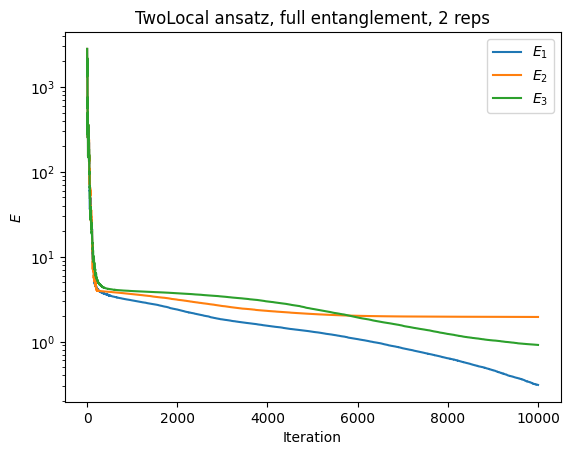

In [46]:
run_for_ansatz(TwoLocal(nq, rotation_blocks='ry', entanglement_blocks='cx', entanglement='full', reps=2),maxiter=10000)

[0.15354348+0.j 1.16742536+0.j 2.00383703+0.j]


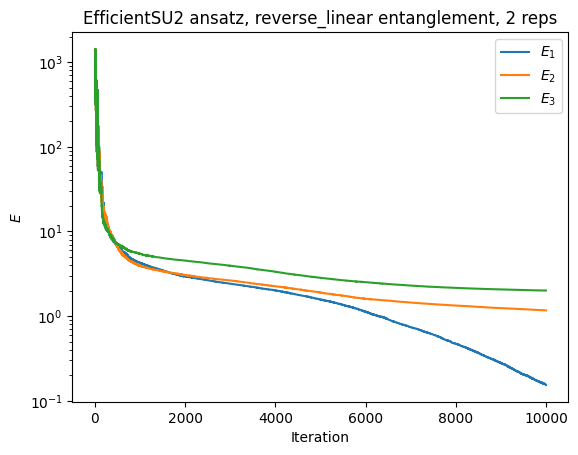

In [48]:
run_for_ansatz(EfficientSU2(nq, reps=2), maxiter=10000)

[0.08467118+0.j 1.02305117+0.j 1.7241148 +0.j]


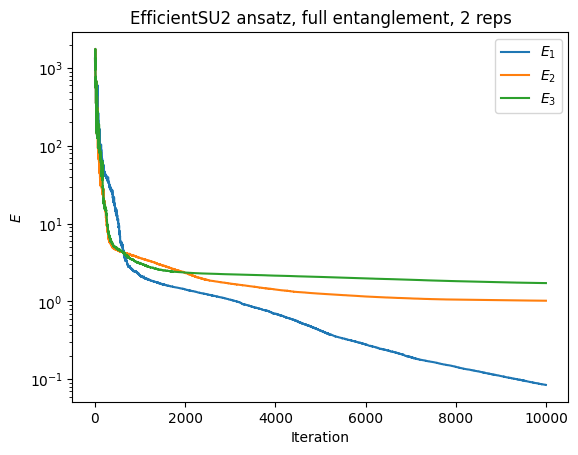

In [49]:
run_for_ansatz(EfficientSU2(nq, entanglement='full', reps=2), maxiter=10000)

[0.08340403+0.j 1.48601472+0.j 1.71960695+0.j]


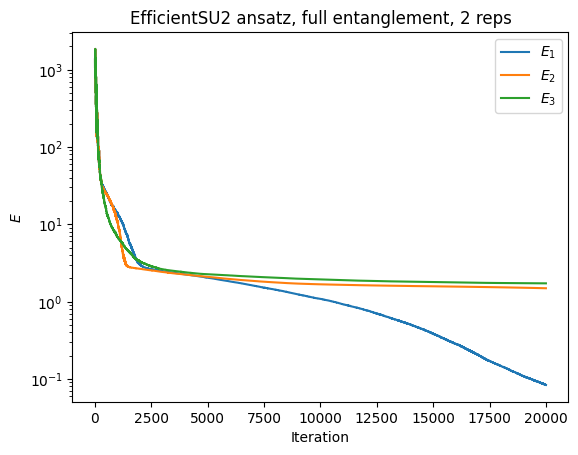

In [50]:
run_for_ansatz(EfficientSU2(nq, entanglement='full', reps=2), maxiter=20000)